In [25]:
import warnings
warnings.filterwarnings("ignore")

In [20]:
import csv
import pandas as pd

data = pd.read_csv('data/GlobalLandTemperaturesByCity.csv',sep=',',index_col=False)

poland_data = data[data['Country'] == 'Poland']

poland_data.to_csv('poland_data.csv',index=False)

In [26]:
# Listing unique cities in poland_data

list_city = list(pd.unique(poland_data['City']))
list_city

['Bialystok',
 'Bielsko Biala',
 'Bydgoszcz',
 'Bytom',
 'Chorzow',
 'Cracow',
 'Czestochowa',
 'Dabrowa Gornicza',
 'Elblag',
 'Gdansk',
 'Gdynia',
 'Gliwice',
 'Gorzow Wielkopolski',
 'Kalisz',
 'Katowice',
 'Kielce',
 'Koszalin',
 'Legnica',
 'Lublin',
 'Olsztyn',
 'Opole',
 'Plock',
 'Poznan',
 'Radom',
 'Ruda Slaska',
 'Rybnik',
 'Rzeszow',
 'Sosnowiec',
 'Szczecin',
 'Tarnow',
 'Torun',
 'Tychy',
 'Walbrzych',
 'Warsaw',
 'Wloclawek',
 'Wroclaw',
 'Zabrze',
 'Zielona Gora']

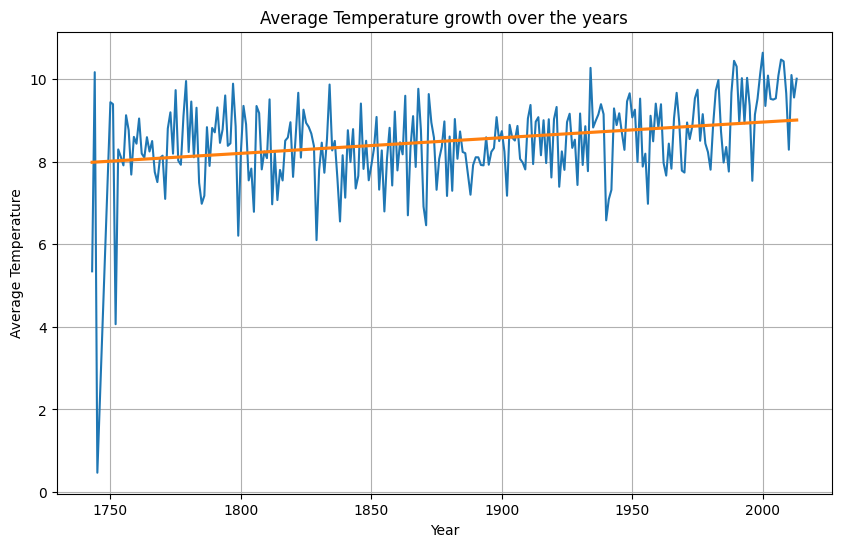

In [29]:
# I choose Poznan as the main city, now i want to create a visualization that will show the growth of temperature over the years

import seaborn as sns
import matplotlib.pyplot as plt


# creating Poznan dataset
df_poznan = poland_data[poland_data['City']=='Poznan']

# extracting year form date
df_poznan['dt'] = pd.to_datetime(df_poznan['dt'])
df_poznan['Year'] = df_poznan['dt'].dt.year

# dropping NA values
df_poznan.dropna(subset=['AverageTemperature'],inplace=True)

plt.figure(figsize=(10,6))
ax = sns.lineplot(x='Year',y='AverageTemperature',data=df_poznan,ci=None)
sns.regplot(x='Year', y='AverageTemperature',data=df_poznan,ci=None,scatter=False,ax=ax)

plt.title("Average Temperature growth over the years")
plt.xlabel("Year")
plt.ylabel("Average Temperature")
plt.grid(True)
plt.show()




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


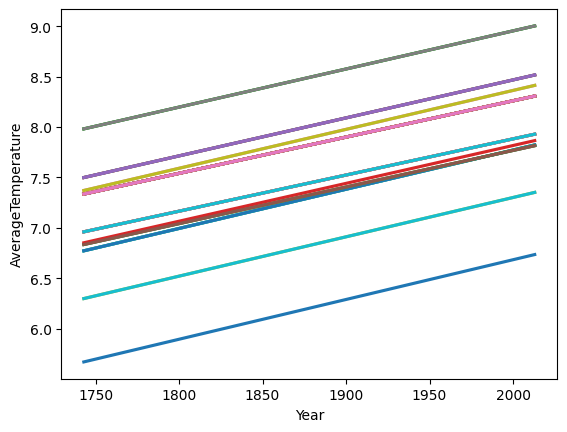

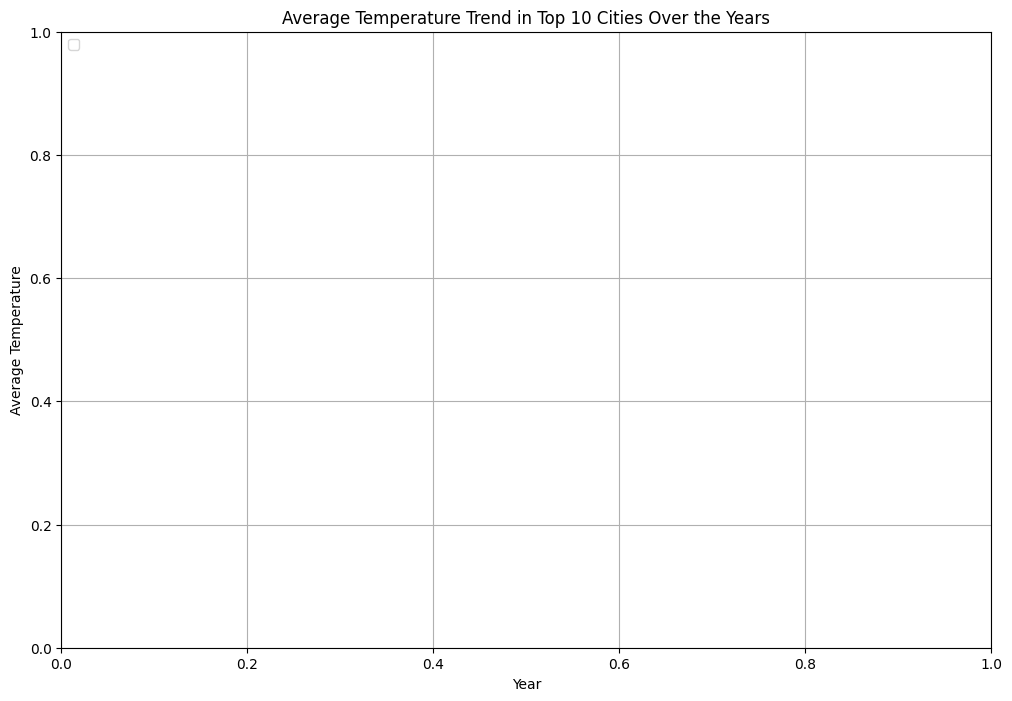

In [41]:
# now I want to create a new dataframe that contains countries column and column with value that is calculated by subtracing highest value on regression line by lowest value

# cleaning dataset to prevent future problems with NA values
df_clean = poland_data.dropna(subset=['AverageTemperature'])

df_clean['dt'] = pd.to_datetime(df_clean['dt'])
df_clean['Year'] = df_clean['dt'].dt.year

# creating dataframe that will contains cities and said subtraction values
result_df = pd.DataFrame(columns=['City','Subtraction'])

grouped = df_clean.groupby('City')

for city, group in grouped:
    if len(group['Year']) >= 2:
        # Fit the linear regression model
        reg_model = sns.regplot(x='Year', y='AverageTemperature', data=group, ci=None, scatter=False)
        slope, intercept = reg_model.get_lines()[0].get_data()
        
        # Calculate the highest and lowest regression line points
        highest_point = slope.max() * slope + intercept.max()
        lowest_point = slope.min() * slope + intercept.min()
        
        # Calculate the subtraction and store the result in the new DataFrame
        subtraction = highest_point - lowest_point
        result_df = result_df.append({'City': city, 'Subtraction': subtraction}, ignore_index=True)


# fixing 'subtraction' column to numeric data type
result_df['Subtraction'] = pd.to_numeric(result_df['Subtraction'], errors='coerce')
result_df.dropna(subset=['Subtraction'], inplace=True)

# getting top 10 cities
top_10_cities = result_df.nlargest(10, 'Subtraction')

# Create a line plot with regression lines for the top 10 cities
plt.figure(figsize=(12, 8))
line_artists = []  # Collect regression line artists
for city in top_10_cities['City']:
    group = grouped.get_group(city)
    reg_model = sns.regplot(x='Year', y='AverageTemperature', data=group, ci=None, label=city)
    line_artists.append(reg_model.lines[0])  # Append the line artist to the list

plt.title('Average Temperature Trend in Top 10 Cities Over the Years')
plt.xlabel('Year')
plt.ylabel('Average Temperature')

# Create the legend using the line artists and city names
plt.legend(handles=line_artists, labels=top_10_cities['City'].tolist(), loc='upper left')
plt.grid(True)
plt.show()
